In [8]:
# Install BeautifulSoup (only needed in Colab / fresh envs)
!pip install -q beautifulsoup4

# Imports
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("Imports ready.")


Imports ready.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Sample HTML Pages (strings)

In [9]:
# Small example website: pages A, B, C, D as HTML strings
pages = {
    "A": "<html><body><h1>Page A</h1>"
         "<a href='B'>B</a> <a href='C'>C</a></body></html>",
    "B": "<html><body><h1>Page B</h1>"
         "<a href='C'>C</a></body></html>",
    "C": "<html><body><h1>Page C</h1>"
         "<a href='A'>A</a> <a href='D'>D</a></body></html>",
    "D": "<html><body><h1>Page D</h1>"
         "<!-- D has no outgoing links (dangling) -->"
         "</body></html>"
}

print("Pages defined:", list(pages.keys()))


Pages defined: ['A', 'B', 'C', 'D']


Parse HTML with BeautifulSoup & Build Graph

In [10]:
# Build adjacency list (outlinks) from parsed HTML
graph = {p: set() for p in pages}

for name, html in pages.items():
    soup = BeautifulSoup(html, "html.parser")
    for a in soup.find_all("a"):
        href = a.get("href")
        # Only keep internal links that point to our sample pages
        if href in pages:
            graph[name].add(href)

# Display adjacency (outlinks)
for p, outs in graph.items():
    print(f"{p} -> {sorted(list(outs))}")


A -> ['B', 'C']
B -> ['C']
C -> ['A', 'D']
D -> []


Build Column-Stochastic Matrix from Graph

In [11]:
# Create ordered list of nodes
nodes = sorted(graph.keys())
N = len(nodes)
index = {node: i for i, node in enumerate(nodes)}

# Column-stochastic matrix M where M[j,i] = 1/outdeg(i) if i -> j
M = np.zeros((N, N), dtype=float)

for i, node in enumerate(nodes):
    outlinks = graph[node]
    if len(outlinks) == 0:
        # dangling node: treat as linking to all nodes equally
        M[:, i] = 1.0 / N
    else:
        weight = 1.0 / len(outlinks)
        for dest in outlinks:
            j = index[dest]
            M[j, i] = weight

# Show matrix as DataFrame for clarity
pd.DataFrame(M, index=nodes, columns=nodes)


,A,B,C,D
A,0.0,0.0,0.5,0.25
B,0.5,0.0,0.0,0.25
C,0.5,1.0,0.0,0.25
D,0.0,0.0,0.5,0.25


PageRank Function

In [12]:
def pagerank_from_matrix(M, damping=0.85, tol=1e-6, max_iter=100):
    """
    M : column-stochastic numpy array (shape N x N)
    damping : damping factor (0 < damping < 1)
    returns: numpy array of PageRank scores (length N), iterations used
    """
    N = M.shape[0]
    pr = np.ones(N) / N           # initial uniform ranks
    teleport = np.ones(N) / N     # teleport / random jump vector

    for it in range(1, max_iter+1):
        new_pr = damping * (M @ pr) + (1 - damping) * teleport
        err = np.abs(new_pr - pr).sum()   # L1 norm
        pr = new_pr
        if err < tol:
            return pr, it, err
    return pr, max_iter, err


Run PageRank on Our Graph

In [13]:
scores, iterations, final_err = pagerank_from_matrix(M, damping=0.85)
print(f"Converged in {iterations} iterations, final L1 change = {final_err:.2e}")

# Map scores back to page labels and show sorted
scores_dict = {node: float(scores[index[node]]) for node in nodes}
df_scores = pd.DataFrame.from_dict(scores_dict, orient='index', columns=['PageRank'])
df_scores = df_scores.sort_values('PageRank', ascending=False)
df_scores


Converged in 21 iterations, final L1 change = 4.89e-07


,PageRank
C,0.345342
A,0.233994
D,0.233994
B,0.186671


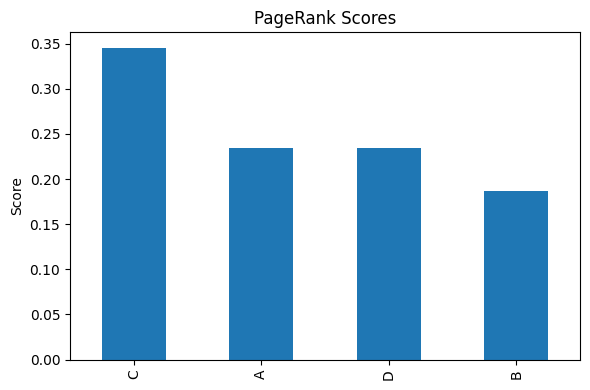

In [14]:
# Bar plot
df_scores.plot(kind='bar', legend=False, figsize=(6,4))
plt.title("PageRank Scores")
plt.ylabel("Score")
plt.tight_layout()
plt.show()
